In [1]:
# Author: Tyler Lanigan <tylerlanigan@gmail.com>
#         Sebastian Raschka <mail@sebastianraschka.com>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
scaled_X_train = scaler.fit_transform(X_train)

Feature scaling

Effect of rescaling on a k-neighbors models

For the sake of visualizing the decision boundary of a KNeighborsClassifier, in this section we select a subset of 2 features that have values with different orders of magnitude.

Keep in mind that using a subset of the features to train the model may likely leave out feature with high predictive impact, resulting in a decision boundary that is much worse in comparison to a model trained on the full set of features.
Here the decision boundary shows that fitting scaled or non-scaled data lead to completely different models. The reason is that the variable “proline” has values which vary between 0 and 1,000; whereas the variable “hue” varies between 1 and 10. Because of this, distances between samples are mostly impacted by differences in values of “proline”, while values of the “hue” will be comparatively ignored. If one uses StandardScaler to normalize this database, both scaled values lay approximately between -3 and 3 and the neighbors structure will be impacted more or less equivalently by both variables.



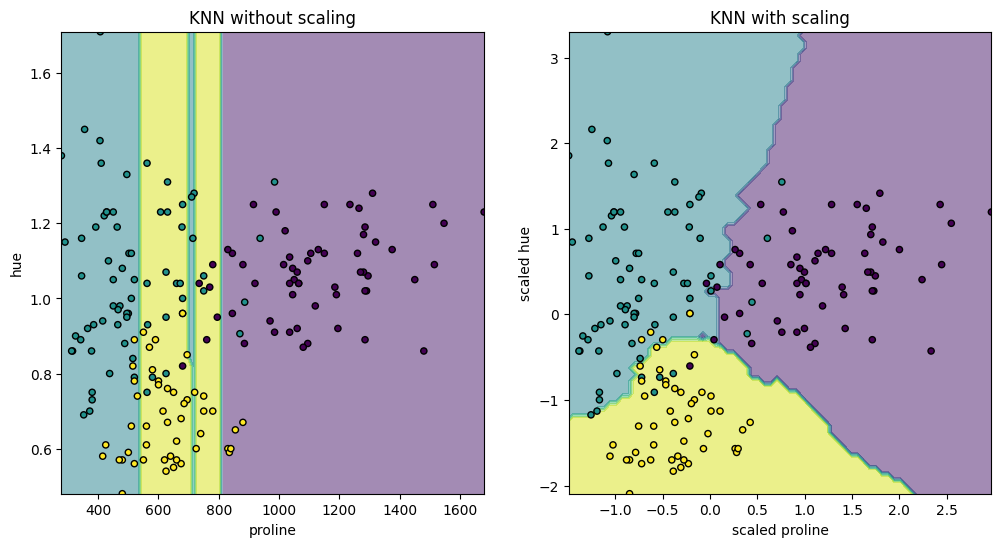

In [2]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)


def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")

In [3]:
print(scaler.__dict__)
print(scaler.mean_)
print(scaler.var_)

{'with_mean': True, 'with_std': True, 'copy': True, '_sklearn_output_config': {'transform': 'pandas'}, 'feature_names_in_': array(['proline', 'hue'], dtype=object), 'n_features_in_': 2, 'n_samples_seen_': np.int64(178), 'mean_': array([746.89325843,   0.95744944]), 'var_': array([9.86096010e+04, 5.19514497e-02]), 'scale_': array([3.14021657e+02, 2.27928607e-01])}
[746.89325843   0.95744944]
[9.86096010e+04 5.19514497e-02]


Effect of rescaling on a PCA dimensional reduction

Dimensional reduction using PCA consists of finding the features that maximize the variance. If one feature varies more than the others only because of their respective scales, PCA would determine that such feature dominates the direction of the principal components.

Indeed we find that the “proline” feature dominates the direction of the first principal component without scaling, being about two orders of magnitude above the other features. This is contrasted when observing the first principal component for the scaled version of the data, where the orders of magnitude are roughly the same across all the features.
From the plot above we observe that scaling the features before reducing the dimensionality results in components with the same order of magnitude. In this case it also improves the separability of the classes. Indeed, in the next section we confirm that a better separability has a good repercussion on the overall model’s performance.

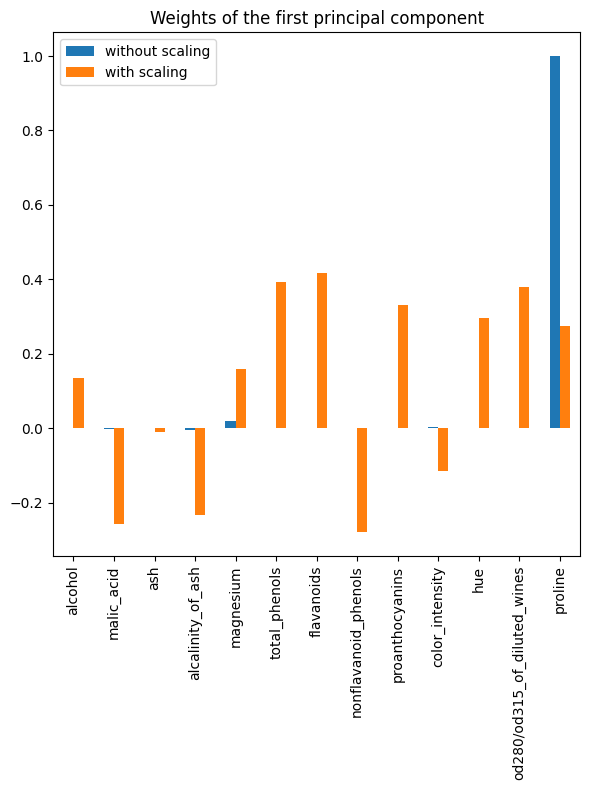

In [4]:
import pandas as pd

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
X_train_transformed = pca.transform(X_train)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(6, 8)
)

_ = plt.tight_layout()

In [5]:
pca.__dict__

{'n_components': 2,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'feature_names_in_': array(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
        'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
        'proanthocyanins', 'color_intensity', 'hue',
        'od280/od315_of_diluted_wines', 'proline'], dtype=object),
 'n_features_in_': 13,
 '_fit_svd_solver': 'full',
 'mean_': array([1.29633065e+01, 2.40298387e+00, 2.36661290e+00, 1.95000000e+01,
        1.00879032e+02, 2.27330645e+00, 2.00733871e+00, 3.64193548e-01,
        1.59298387e+00, 4.97403226e+00, 9.59322581e-01, 2.60032258e+00,
        7.37266129e+02]),
 'noise_variance_': np.float64(1.5741396498972315),
 'n_samples_': 124,
 'n_components_': 2,
 'components_': array([[ 1.76342917e-03, -8.35544737e-04,  1.54623496e-04,
         -5.31136096e-03,  2.01663336e-02,  1.024406

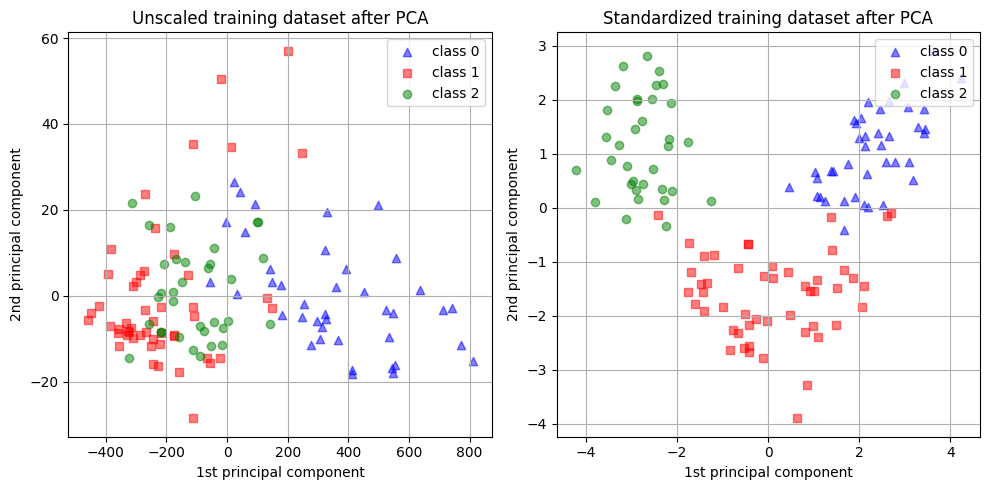

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 3)
colors = ("blue", "red", "green")
markers = ("^", "s", "o")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=X_train_transformed[y_train == target_class, 0],
        y=X_train_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

    ax2.scatter(
        x=X_train_std_transformed[y_train == target_class, 0],
        y=X_train_std_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

Effect of rescaling on model’s performance

First we show how the optimal regularization of a LogisticRegressionCV depends on the scaling or non-scaling of the data:
The need for regularization is higher (lower values of C) for the data that was not scaled before applying PCA. We now evaluate the effect of scaling on the accuracy and the mean log-loss of the optimal models:

In [7]:
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

Cs = np.logspace(-5, 5, 20)

unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs))
unscaled_clf.fit(X_train, y_train)

scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs))
scaled_clf.fit(X_train, y_train)

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")

Optimal C for the unscaled PCA: 0.0004

Optimal C for the standardized data with PCA: 20.69


A clear difference in prediction accuracies is observed when the data is scaled before PCA, as it vastly outperforms the unscaled version. This corresponds to the intuition obtained from the plot in the previous section, where the components become linearly separable when scaling before using PCA.

Notice that in this case the models with scaled features perform better than the models with non-scaled features because all the variables are expected to be predictive and we rather avoid some of them being comparatively ignored.

If the variables in lower scales were not predictive, one may experience a decrease of the performance after scaling the features: noisy features would contribute more to the prediction after scaling and therefore scaling would increase overfitting.

Last but not least, we observe that one achieves a lower log-loss by means of the scaling step.

In [8]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

print("Test accuracy for the unscaled PCA")
print(f"{accuracy_score(y_test, y_pred):.2%}\n")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")
print("Log-loss for the unscaled PCA")
print(f"{log_loss(y_test, y_proba):.3}\n")
print("Log-loss for the standardized data with PCA")
print(f"{log_loss(y_test, y_proba_scaled):.3}")

Test accuracy for the unscaled PCA
35.19%

Test accuracy for the standardized data with PCA
96.30%

Log-loss for the unscaled PCA
0.957

Log-loss for the standardized data with PCA
0.0825


Power transformations

The power transform is useful as a transformation in modeling problems where homoscedasticity and normality are desired. Below are examples of Box-Cox and Yeo-Johnwon applied to six different probability distributions: Lognormal, Chi-squared, Weibull, Gaussian, Uniform, and Bimodal.
Note that the transformations successfully map the data to a normal distribution when applied to certain datasets, but are ineffective with others. This highlights the importance of visualizing the data before and after transformation.
Also note that even though Box-Cox seems to perform better than Yeo-Johnson for lognormal and chi-squared distributions, keep in mind that Box-Cox does not support inputs with negative values.
For comparison, we also add the output from preprocessing.QuantileTransformer. It can force any arbitrary distribution into a gaussian, provided that there are enough training samples (thousands). Because it is a non-parametric method, it is harder to interpret than the parametric ones (Box-Cox and Yeo-Johnson).
On “small” datasets (less than a few hundred points), the quantile transformer is prone to overfitting. The use of the power transform is then recommended.

In [9]:
# Author: Eric Chang <ericchang2017@u.northwestern.edu>
#         Nicolas Hug <contact@nicolas-hug.com>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

N_SAMPLES = 1000
FONT_SIZE = 6
BINS = 30


rng = np.random.RandomState(304)
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=rng
)
size = (N_SAMPLES, 1)

In [10]:
# lognormal distribution
X_lognormal = rng.lognormal(size=size)

# chi-squared distribution
df = 3
X_chisq = rng.chisquare(df=df, size=size)

# weibull distribution
a = 50
X_weibull = rng.weibull(a=a, size=size)

# gaussian distribution
loc = 100
X_gaussian = rng.normal(loc=loc, size=size)

# uniform distribution
X_uniform = rng.uniform(low=0, high=1, size=size)

# bimodal distribution
loc_a, loc_b = 100, 105
X_a, X_b = rng.normal(loc=loc_a, size=size), rng.normal(loc=loc_b, size=size)
X_bimodal = np.concatenate([X_a, X_b], axis=0)

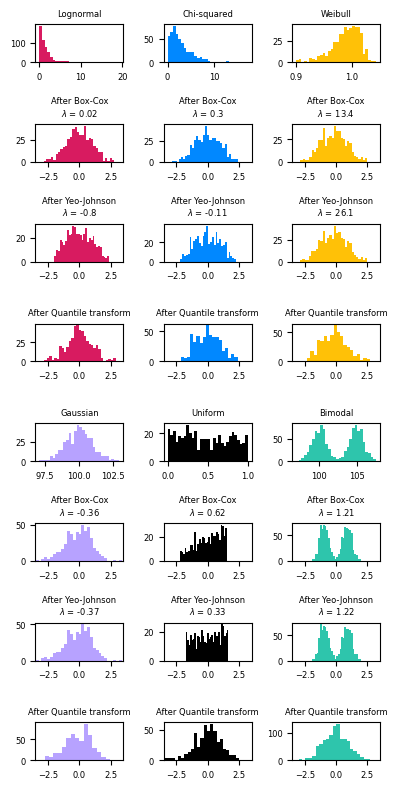

In [11]:
# create plots
distributions = [
    ("Lognormal", X_lognormal),
    ("Chi-squared", X_chisq),
    ("Weibull", X_weibull),
    ("Gaussian", X_gaussian),
    ("Uniform", X_uniform),
    ("Bimodal", X_bimodal),
]

colors = ["#D81B60", "#0188FF", "#FFC107", "#B7A2FF", "#000000", "#2EC5AC"]

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=plt.figaspect(2))
axes = axes.flatten()
axes_idxs = [
    (0, 3, 6, 9),
    (1, 4, 7, 10),
    (2, 5, 8, 11),
    (12, 15, 18, 21),
    (13, 16, 19, 22),
    (14, 17, 20, 23),
]
axes_list = [(axes[i], axes[j], axes[k], axes[l]) for (i, j, k, l) in axes_idxs]

for distribution, color, axes in zip(distributions, colors, axes_list):
    name, X = distribution
    X_train, X_test = train_test_split(X, test_size=0.5)

    # perform power transforms and quantile transform
    X_trans_bc = bc.fit(X_train).transform(X_test)
    lmbda_bc = round(bc.lambdas_[0], 2)
    X_trans_yj = yj.fit(X_train).transform(X_test)
    lmbda_yj = round(yj.lambdas_[0], 2)
    X_trans_qt = qt.fit(X_train).transform(X_test)

    ax_original, ax_bc, ax_yj, ax_qt = axes

    ax_original.hist(X_train, color=color, bins=BINS)
    ax_original.set_title(name, fontsize=FONT_SIZE)
    ax_original.tick_params(axis="both", which="major", labelsize=FONT_SIZE)

    for ax, X_trans, meth_name, lmbda in zip(
        (ax_bc, ax_yj, ax_qt),
        (X_trans_bc, X_trans_yj, X_trans_qt),
        ("Box-Cox", "Yeo-Johnson", "Quantile transform"),
        (lmbda_bc, lmbda_yj, None),
    ):
        ax.hist(X_trans, color=color, bins=BINS)
        title = "After {}".format(meth_name)
        if lmbda is not None:
            title += "\n$\\lambda$ = {}".format(lmbda)
        ax.set_title(title, fontsize=FONT_SIZE)
        ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE)
        ax.set_xlim([-3.5, 3.5])


plt.tight_layout()
plt.show()

In [12]:
print("BC",bc.__dict__)

BC {'method': 'box-cox', 'standardize': True, 'copy': True, 'n_features_in_': 1, 'lambdas_': array([1.21221962]), '_scaler': StandardScaler(copy=False)}


In [13]:
print("YJ",bc.__dict__)

YJ {'method': 'box-cox', 'standardize': True, 'copy': True, 'n_features_in_': 1, 'lambdas_': array([1.21221962]), '_scaler': StandardScaler(copy=False)}


In [14]:
print("QT",qt.__dict__)

QT {'n_quantiles': 500, 'output_distribution': 'normal', 'ignore_implicit_zeros': False, 'subsample': 10000, 'random_state': RandomState(MT19937) at 0x1440B9340, 'copy': True, 'n_features_in_': 1, 'n_quantiles_': 500, 'references_': array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615,
       0.04008016, 0.04208417, 0.04408818, 0.04609218, 0.04809619,
       0.0501002 , 0.05210421, 0.05410822, 0.05611222, 0.05811623,
       0.06012024, 0.06212425, 0.06412826, 0.06613226, 0.06813627,
       0.07014028, 0.07214429, 0.0741483 , 0.0761523 , 0.07815631,
       0.08016032, 0.08216433, 0.08416834, 0.08617234, 0.08817635,
       0.09018036, 0.09218437, 0.09418838, 0.09619238, 0.09819639,
       0.1002004 , 0.10220441, 0.10420842, 0.10621242, 0.10821643,
       0.11022044, 0.11222445,

General data preprocessing

In [15]:
# Source: https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn import preprocessing
import numpy as np
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler().fit(X_train)
print(scaler, scaler.__dict__)

print(scaler.mean_)

print(scaler.scale_)

X_scaled = scaler.transform(X_train)
print(X_scaled)

StandardScaler() {'with_mean': True, 'with_std': True, 'copy': True, 'n_features_in_': 3, 'n_samples_seen_': np.int64(3), 'mean_': array([1.        , 0.        , 0.33333333]), 'var_': array([0.66666667, 0.66666667, 1.55555556]), 'scale_': array([0.81649658, 0.81649658, 1.24721913])}
[1.         0.         0.33333333]
[0.81649658 0.81649658 1.24721913]
[[ 0.         -1.22474487  1.33630621]
 [ 1.22474487  0.         -0.26726124]
 [-1.22474487  1.22474487 -1.06904497]]


In [16]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.96

In [17]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
print(min_max_scaler.__dict__)
print(X_train_minmax)

{'feature_range': (0, 1), 'copy': True, 'clip': False, 'n_features_in_': 3, 'n_samples_seen_': 3, 'scale_': array([0.5       , 0.5       , 0.33333333]), 'min_': array([0.        , 0.5       , 0.33333333]), 'data_min_': array([ 0., -1., -1.]), 'data_max_': array([2., 1., 2.]), 'data_range_': array([2., 2., 3.])}
[[0.5        0.         1.        ]
 [1.         0.5        0.33333333]
 [0.         1.         0.        ]]


In [18]:
X_test = np.array([[-3., -1.,  4.]])
X_test_minmax = min_max_scaler.transform(X_test)
print(X_test_minmax)

[[-1.5         0.          1.66666667]]


In [19]:
print(min_max_scaler.scale_)

print(min_max_scaler.min_)

[0.5        0.5        0.33333333]
[0.         0.5        0.33333333]


In [20]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
max_abs_scaler = preprocessing.MaxAbsScaler()
print(max_abs_scaler.__dict__)
X_train_maxabs = max_abs_scaler.fit_transform(X_train)
print(X_train_maxabs)
X_test = np.array([[ -3., -1.,  4.]])
X_test_maxabs = max_abs_scaler.transform(X_test)
print(X_test_maxabs)
print(max_abs_scaler.scale_)

{'copy': True}
[[ 0.5 -1.   1. ]
 [ 1.   0.   0. ]
 [ 0.   1.  -0.5]]
[[-1.5 -1.   2. ]]
[2. 1. 2.]


In [21]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]
X_normalized = preprocessing.normalize(X, norm='l2')

X_normalized

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [22]:
normalizer = preprocessing.Normalizer().fit(X)  # fit does nothing
normalizer.transform(X)
normalizer.transform([[-1.,  1., 0.]])

array([[-0.70710678,  0.70710678,  0.        ]])

In [23]:
enc = preprocessing.OrdinalEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
print(enc.__dict__)
enc.transform([['female', 'from US', 'uses Safari']])

{'categories': 'auto', 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'error', 'unknown_value': None, 'encoded_missing_value': nan, 'min_frequency': None, 'max_categories': None, '_infrequent_enabled': False, 'n_features_in_': 3, 'categories_': [array(['female', 'male'], dtype=object), array(['from Europe', 'from US'], dtype=object), array(['uses Firefox', 'uses Safari'], dtype=object)], '_missing_indices': {}}


array([[0., 1., 1.]])

In [24]:
enc = preprocessing.OrdinalEncoder()
X = [['male'], ['female'], [np.nan], ['female']]
enc.fit_transform(X)

array([[ 1.],
       [ 0.],
       [nan],
       [ 0.]])

In [25]:
enc = preprocessing.OrdinalEncoder(encoded_missing_value=-1)
X = [['male'], ['female'], [np.nan], ['female']]
enc.fit_transform(X)

array([[ 1.],
       [ 0.],
       [-1.],
       [ 0.]])

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
enc = Pipeline(steps=[
    ("encoder", preprocessing.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
])
enc.fit_transform(X)


array([[ 1.],
       [ 0.],
       [-1.],
       [ 0.]])

In [27]:
enc = preprocessing.OneHotEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from US', 'uses Safari'],
               ['male', 'from Europe', 'uses Safari']]).toarray()

array([[1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 1.]])

In [28]:
enc.categories_

[array(['female', 'male'], dtype=object),
 array(['from Europe', 'from US'], dtype=object),
 array(['uses Firefox', 'uses Safari'], dtype=object)]

In [29]:
genders = ['female', 'male']
locations = ['from Africa', 'from Asia', 'from Europe', 'from US']
browsers = ['uses Chrome', 'uses Firefox', 'uses IE', 'uses Safari']
enc = preprocessing.OneHotEncoder(categories=[genders, locations, browsers])
# Note that for there are missing categorical values for the 2nd and 3rd
# feature
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [30]:
enc = preprocessing.OneHotEncoder(handle_unknown='infrequent_if_exist')
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

array([[1., 0., 0., 0., 0., 0.]])

In [31]:
X = [['male', 'from US', 'uses Safari'],
     ['female', 'from Europe', 'uses Firefox']]
drop_enc = preprocessing.OneHotEncoder(drop='first').fit(X)
drop_enc.categories_
drop_enc.transform(X).toarray()

array([[1., 1., 1.],
       [0., 0., 0.]])

In [32]:
X = np.array([['dog'] * 5 + ['cat'] * 20 + ['rabbit'] * 10 +
              ['snake'] * 3], dtype=object).T
enc = preprocessing.OrdinalEncoder(min_frequency=6).fit(X)
enc.infrequent_categories_
enc.transform(np.array([['dog'], ['cat'], ['rabbit'], ['snake']]))

array([[2.],
       [0.],
       [1.],
       [2.]])

In [33]:
X_train = np.array(
    [["a"] * 5 + ["b"] * 20 + ["c"] * 10 + ["d"] * 3 + [np.nan]],
    dtype=object).T
enc = preprocessing.OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=3,
    max_categories=3, encoded_missing_value=4)
_ = enc.fit(X_train)
X_test = np.array([["a"], ["b"], ["c"], ["d"], ["e"], [np.nan]], dtype=object)
enc.transform(X_test)

array([[2.],
       [0.],
       [1.],
       [2.],
       [3.],
       [4.]])

In [34]:
enc = preprocessing.OneHotEncoder(min_frequency=6, sparse_output=False).fit(X)
enc.infrequent_categories_
enc.transform(np.array([['dog'], ['cat'], ['rabbit'], ['snake']]))

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [35]:
enc = preprocessing.OneHotEncoder(
   handle_unknown='infrequent_if_exist', sparse_output=False, min_frequency=6)
enc = enc.fit(X)
enc.transform(np.array([['dragon']]))

array([[0., 0., 1.]])

In [36]:
enc.get_feature_names_out()

array(['x0_cat', 'x0_rabbit', 'x0_infrequent_sklearn'], dtype=object)

In [37]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

binarizer = preprocessing.Binarizer().fit(X)  # fit does nothing
binarizer

binarizer.transform(X)

array([[1., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [38]:
binarizer = preprocessing.Binarizer(threshold=1.1)
binarizer.transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 0.]])

In [39]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
X = np.arange(6).reshape(3, 2)
X
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [40]:
X = np.arange(9).reshape(3, 3)
X
poly = PolynomialFeatures(degree=3, interaction_only=True)
poly.fit_transform(X)

array([[  1.,   0.,   1.,   2.,   0.,   0.,   2.,   0.],
       [  1.,   3.,   4.,   5.,  12.,  15.,  20.,  60.],
       [  1.,   6.,   7.,   8.,  42.,  48.,  56., 336.]])

In [41]:
import numpy as np
from sklearn.preprocessing import SplineTransformer
X = np.arange(5).reshape(5, 1)
X
spline = SplineTransformer(degree=2, n_knots=3)
spline.fit_transform(X)

array([[0.5  , 0.5  , 0.   , 0.   ],
       [0.125, 0.75 , 0.125, 0.   ],
       [0.   , 0.5  , 0.5  , 0.   ],
       [0.   , 0.125, 0.75 , 0.125],
       [0.   , 0.   , 0.5  , 0.5  ]])

In [42]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
X = np.array([[0, 1], [2, 3]])
# Since FunctionTransformer is no-op during fit, we can call transform directly
transformer.transform(X)

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])